In [20]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st
import statsmodels.api as sm
import pandas as pd
from scipy.optimize import bisect
from scipy.optimize import root_scalar
from scipy.stats import linregress
import seaborn as sns

In [14]:
def I(sigma, S_0 = 100 , K = 120, r = 0.05, T = 0.2):
    """Closed form solution for the option price of an european put option
    Parameters
    ----------
    sigma : float
        volatility of the geometric brownian motion
    S_0 : float
        Initial value of the geometric brownian motion
    K : float
        strike price of the put option
    r : float
        interest rate of the put option
    sigma : float
        volatility of the geometric brownian motion
    T : float
        time horizon of the put option

    Returns
    -------
    I : float
        Option price"""
    
    w = (np.log(K/S_0) - (r-0.5*sigma**2)*T) / ( sigma * np.sqrt(T) )
    I = np.exp(-r*T) * K * st.norm.cdf(w) - S_0 * st.norm.cdf(w - sigma*np.sqrt(T))
    return I

def Simulate_Stock_Price(S_0,sigma, r, T, m,N):
    """This function returns N GBM, each evaluated at time T/m,...,T with a starting value of S_0

    Parameters
    ----------
    S_0 : float
        Initial value of the geometric Brownian motion
    sigma : float
        Volatility of the geometric Brownian motion
    r : float
        Interest rate of the geometric Brownian motion
    T : float
        Time horizon of the geometric Brownian motion 
    m : int
        Number of time steps
    N : int
        Number of GBM to generate

    Returns
    -------
    S : np.ndarray
        N GBM evaluated at time T/m,...,T (N_features, m_features)
    """
    simulations = np.ndarray((N, m))
    expXt = st.lognorm.rvs(s=np.sqrt(sigma ** 2 * T / m), loc=0, scale=np.exp((r - 0.5 * sigma ** 2) * T / m), size=m*N)
    expXt_reshaped = expXt.reshape((N, m), order='F')  # Reshape the array to m rows and N columns
    simulations = np.cumprod(np.concatenate([np.ones((N, 1)) * S_0, expXt_reshaped], axis=1), axis=1)
    return simulations[:, 1:]

def RM_European(n, N, rho, K, S0, T, r, I_market,sigma_0 = 1):
    """This function returns the estimated volatility for the option price to equal to market price using the Robbins-Monro algorithm
    Parameters
    ----------
    n : int
        Number of iterations
    N : int    
        Number of MonteCarlo simulation to approximate J
    rho : float
        Agressivness of the algorithm
    K : float   
        Strike price of the put option
    S0 : float
        Initial value of the geometric Brownian motion
    T : float   
        Time horizon of the geometric Brownian motion
    r : float
        Interest rate of the geometric Brownian motion
    I_market : float    
        Market price of the option
    sigma_0 : float
        Initial guess of the volatility

    Returns
    -------
    sigma_estim : np.ndarray
        Estimated volatility at each iteration  (n_features, )
    """
    alpha_0 = 2/(K+S0) # Fixed constant in the algorithm

    sigma_estim = np.empty((n,))
    sigma_estim[0] = sigma_0
    
    for i in range(1, n):
        alpha_n = alpha_0 / i ** rho
        sigma_cur = sigma_estim[i - 1]

        # Compute Jhat
        stock_prices = Simulate_Stock_Price(S0, sigma_cur, r, T, m=1, N=N)
        payoffs = np.exp(-r*T) * np.maximum(K - stock_prices, 0)
        Jhat = np.mean(payoffs) - I_market

        sigma_estim[i] = sigma_cur - alpha_n * Jhat

    return sigma_estim

Question 1: Retrieve the true volatility 

In [15]:
I_m = 22
sigma_opt = bisect(lambda sigma: I(sigma) - I_m, 0.01, 10)
print(sigma_opt)
print()
print(f" The sigma optimal for Imarket = {I_m} is sigma_opt = {sigma_opt}")
print()
print(f" This is a pretty good approximation since with this sigma_opt we obtain that I(sigma_opt) = {I(sigma_opt)}")

0.508372926009589

 The sigma optimal for Imarket = 22 is sigma_opt = 0.508372926009589

 This is a pretty good approximation since with this sigma_opt we obtain that I(sigma_opt) = 21.999999999986855


Question 2: RM algorithm to obtain the volatility

Apply RM Algorithm to find the implied volality. Estimation of the Mean Squared Error (MSE).

rho = 0.8, N = 1, Convergence Rate (against n): 0.20554545215532952
rho = 0.8, N = 10, Convergence Rate (against n): 0.431090436936938
rho = 0.8, N = 100, Convergence Rate (against n): 0.44424638394675264
rho = 1, N = 1, Convergence Rate (against n): 0.3290702048439422
rho = 1, N = 10, Convergence Rate (against n): 0.35031192648073556
rho = 1, N = 100, Convergence Rate (against n): 0.36418867088234963


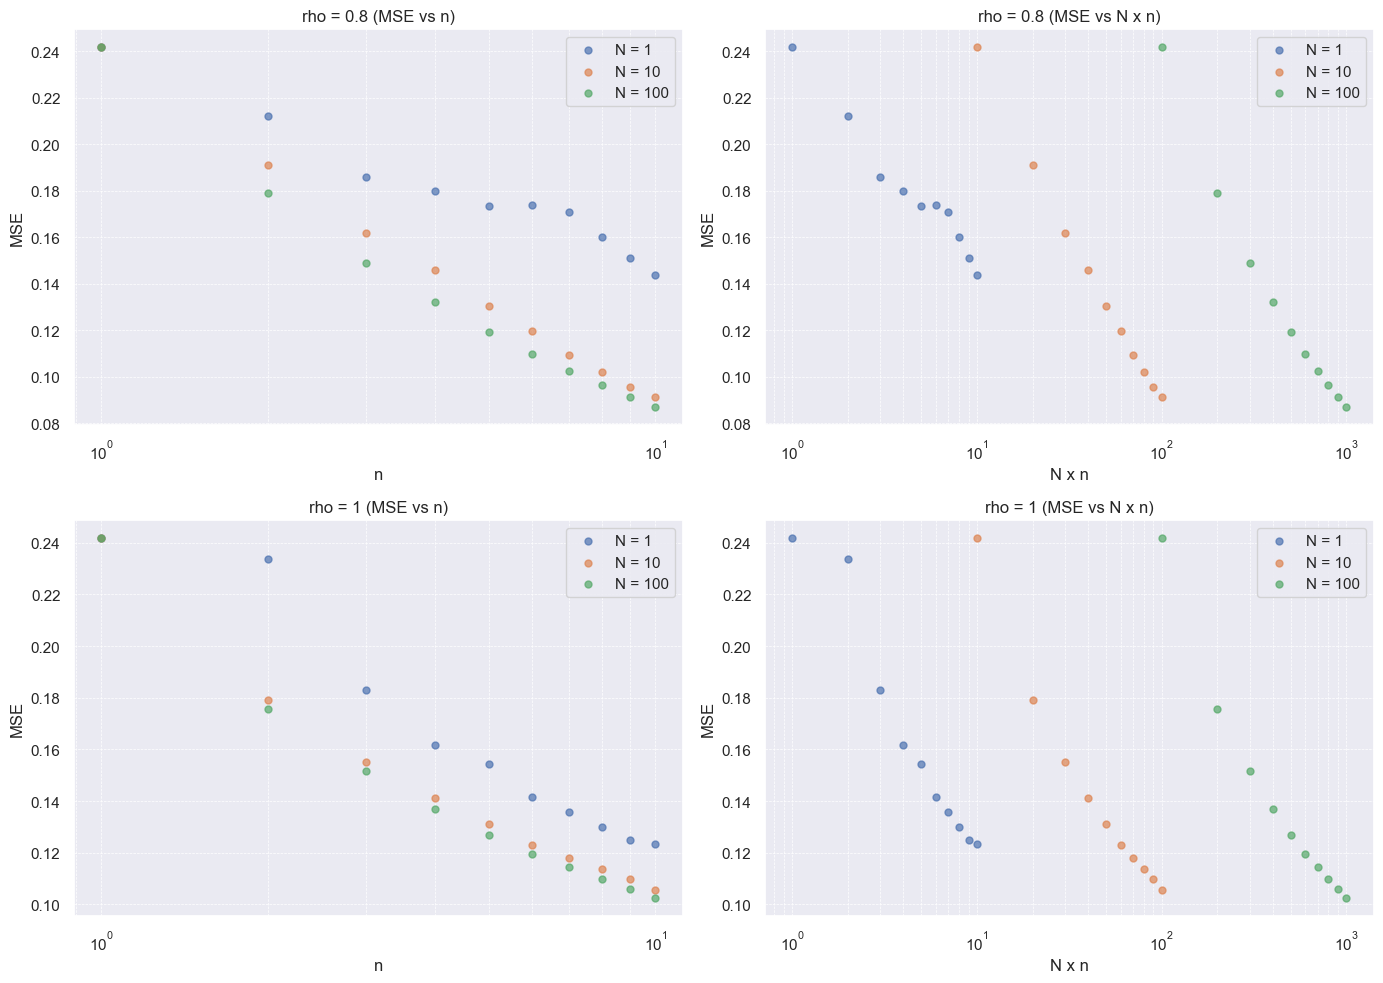

In [23]:
n = 10
iterations = 100
K, S0, r, T, I_market = 120, 100, 0.05, 0.2, 22
# Setting seaborn style
sns.set(style="darkgrid")

# Create a 2x2 subplot using seaborn style
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

for i, rho in enumerate([0.8, 1]):
    axes[i, 0].set_title(f'rho = {rho} (MSE vs n)')
    axes[i, 1].set_title(f'rho = {rho} (MSE vs N x n)')

    for N in [1, 10, 100]:
        all_sigma_estim = np.empty((iterations, n))
        for j in range(iterations):
            all_sigma_estim[j] = RM_European(n, N, rho, K, S0, T, r, I_market)
        MSE = np.mean((all_sigma_estim - sigma_opt)**2, axis=0)

        axes[i, 0].scatter(np.arange(1, n+1), MSE, label=f'N = {N}', s=25, alpha=0.7)
        axes[i, 1].scatter(N * np.arange(1, n+1), MSE, label=f'N = {N}', s=25, alpha=0.7)

        # Calculate convergence rate
        log_n_iterations = np.log(np.arange(1, n+1))
        log_errors = np.log(MSE)
        convergence_rate_n = -linregress(log_n_iterations, log_errors)[0]
        print(f'rho = {rho}, N = {N}, Convergence Rate (against n): {convergence_rate_n}')

    # Setting labels, legends, and log scale for x-axis
    for ax in axes[i, :]:
        ax.set_xscale('log')
        ax.legend()
        ax.set_xlabel('n' if ax == axes[i, 0] else 'N x n')
        ax.set_ylabel('MSE')
        ax.grid(True, which="both", ls="--", linewidth=0.5)

plt.tight_layout()
plt.show()

Part 2: Asian Option 

In [5]:
def RM_Asian(n, N, rho, K, S0, T, r, I_market, m, sigma_0=1):
    """This function returns the estimated volatility for the option price to equal to market price using the Robbins-Monro algorithm
    Parameters
    ----------
    n : int
        Number of iterations
    N : int    
        Number of MonteCarlo simulation to approximate J
    rho : float
        Agressivness of the algorithm
    K : float   
        Strike price of the put option
    S0 : float
        Initial value of the geometric Brownian motion
    T : float   
        Time horizon of the geometric Brownian motion
    r : float
        Interest rate of the geometric Brownian motion
    I_market : float    
        Market price of the option
    m : int
        Number of time steps GBM
    sigma_0 : float
        Initial guess of the volatility
    Returns
    -------
    sigma_estim : np.ndarray
        Estimated volatility at each iteration  (n_features, )
    """
    alpha_0 = 2/(K+S0)

    sigma_estim = np.empty((n,))
    sigma_estim[0] = sigma_0
    
    for i in range(1, n):
        alpha_n = alpha_0 / i ** rho
        sigma_cur = sigma_estim[i - 1]

        # Calculate Jhat
        simulations = Simulate_Stock_Price(S0, sigma_cur, r, T, m, N)
        avg_stock_prices = np.mean(simulations, axis=1)
        payoffs = np.exp(-r*T) * np.maximum(K - avg_stock_prices, 0)
        Jhat = np.mean(payoffs) - I_market
        
        sigma_estim[i] = sigma_cur - alpha_n * Jhat

    return sigma_estim

def RM_Asian_optimized(n, N, rho, K, S0, T, r, I_market, m, sigma_0=1):
    """This function returns the estimated volatility for the option price to equal to market price using a variant of the Robbins-Monro algorithm
    Parameters
    ----------
    n : int
        Number of iterations
    N : int    
        Number of MonteCarlo simulation to approximate J
    rho : float
        Agressivness of the algorithm
    K : float   
        Strike price of the put option
    S0 : float
        Initial value of the geometric Brownian motion
    T : float   
        Time horizon of the geometric Brownian motion
    r : float
        Interest rate of the geometric Brownian motion
    I_market : float    
        Market price of the option
    m : int
        Number of time steps GBM
    sigma_0 : float
        Initial guess of the volatility
    Returns
    -------
    sigma_estim : np.ndarray
        Estimated volatility at each iteration  (n_features, )
    """
    alpha_0 = 2/(K+S0)

    sigma_estim = np.empty((n,))
    sigma_estim[0] = sigma_0
    
    for i in range(1, n):
        alpha_n = alpha_0 / i ** rho
        sigma_cur = sigma_estim[i - 1]

        # Calculate Jhat
        simulations = Simulate_Stock_Price(S0, sigma_cur, r, T, m, N)
        avg_stock_prices = np.mean(simulations, axis=1)
        payoffs = np.exp(-r*T) * np.maximum(K - avg_stock_prices, 0)
        Jhat = np.mean(payoffs) - I_market
        
        sigma_estim[i] = sigma_cur - alpha_n * Jhat

    return sigma_estim

Question 5: Find optimal volatility 

Understand the effect of each parameter in the algorithm

rho: agressivness
Result: it doesnt converge for pho=1, but it does for pho = 0.5 

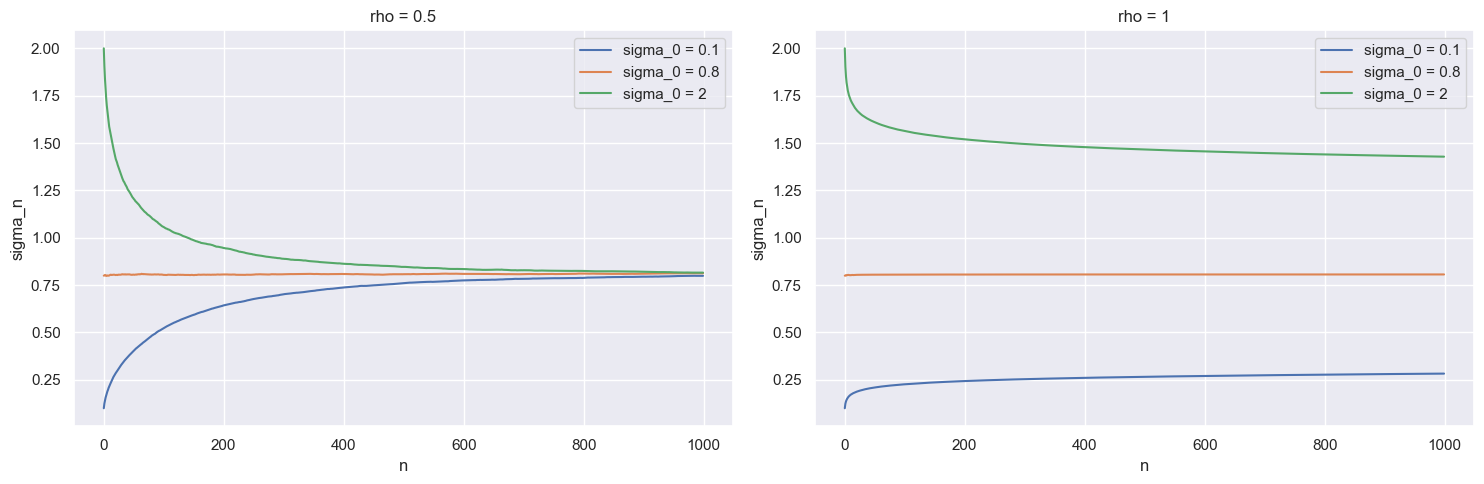

In [35]:
n = 1000
N,m = 1000,50
K, S0, r, T, I_market = 120, 100, 0.05, 0.2, 22
sigma0_values = [0.1,0.8,2]

rho_values =[0.5,1]

# Create a subplot for different rho values
fig, axes = plt.subplots(1,len(rho_values), figsize=(15, 5))

for j, rho in enumerate(rho_values):
    axes[j].set_title(f'rho = {rho}')
    for i, sigma_0 in enumerate(sigma0_values):
        sigmas = RM_Asian(n, N, rho=rho, K=K, S0=S0, T=T, r=r, I_market=I_market, m= m, sigma_0=sigma_0)
        axes[j].plot(range(n), sigmas, label=f'sigma_0 = {sigma_0}')
    
    axes[j].legend()
    axes[j].set_xlabel('n')
    axes[j].set_ylabel('sigma_n')

plt.tight_layout()
plt.show()

N: number of sample for MC estimate of J

Result:
- no added benifit for N>2000, we still have a good amount of variance. Its not that detrimental to the algorithm. we can take N = 10000, but then it will be too slow
- The result with CLt Berry Essen sucks due to lognormality

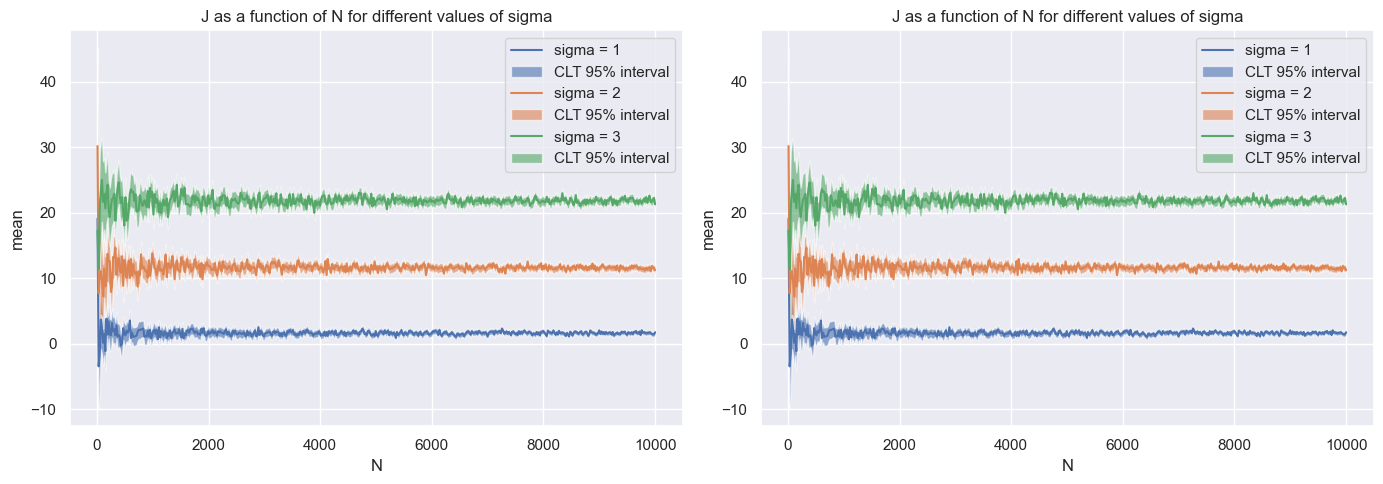

In [113]:
K, S0, r, T, I_market = 120, 100, 0.05, 0.2, 22
m = 50
sigma = [1,2,3]
N = np.linspace(10,10000,500,dtype=int)

mean = np.zeros(shape=(len(N), len(sigma)))
sdev = np.zeros(shape=(len(N), len(sigma)))

for i in range(len(N)):
    for j in range(len(sigma)):
        simulations = Simulate_Stock_Price(S0, sigma[j], r, T, m=m, N=N[i])
        avg_stock_prices = np.mean(simulations, axis=1)
        Z = np.exp(-r*T) * np.maximum(K - avg_stock_prices, 0) - I_market
        mean[i, j] = np.mean(Z)
        sdev[i, j] = np.std(Z)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

for ax in axes:
    for i in range(len(sigma)):
        ax.plot(N, mean[:, i], label=f'sigma = {sigma[i]}')
        ax.fill_between(N, mean[:,i] - 1.96* sdev[:,i] / np.sqrt(N), mean[:,i] + 1.96*sdev[:,i] / np.sqrt(N), alpha=0.6, label=f"CLT 95% interval")

    ax.legend()
    ax.set_xlabel('N')
    ax.set_ylabel('mean')
    ax.set_title('J as a function of N for different values of sigma')

plt.tight_layout()
plt.show()

Estimator J:

- standard deviation of the estimator is a sort of -x^2 curve

Text(0.5, 1.0, 'standard deviation of J estimator as a function of sigma')

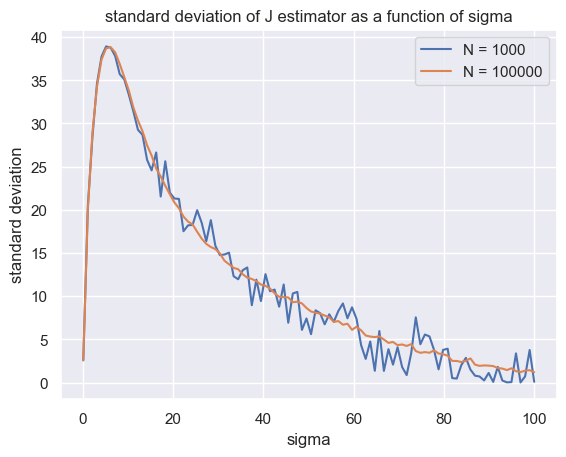

In [64]:
K, S0, r, T, I_market = 120, 100, 0.05, 0.2, 22
m = 50

N = [1000,100000]

sigma = np.linspace(0.1, 100, 100)
sdev = np.zeros(shape=(len(sigma),))

for j in range(len(N)):
    for i in range(len(sigma)):
        simulations = Simulate_Stock_Price(S0, sigma[i], r, T, m= m, N=N[j])
        avg_stock_prices = np.mean(simulations, axis=1)
        Z = np.exp(-r*T) * np.maximum(K - avg_stock_prices, 0) - I_market
        sdev[i] = np.std(Z)
    plt.plot(sigma, sdev, label='N = ' + str(N[j]))

plt.legend()
plt.xlabel('sigma')
plt.ylabel('standard deviation')
plt.title('standard deviation of J estimator as a function of sigma')


Just present CLT, yields same result as Berry Essen

Text(0.5, 1.0, 'Number of simulations (N) needed to have a 95% CLT confidence interval of length 1.0 of J with different values of sigma')

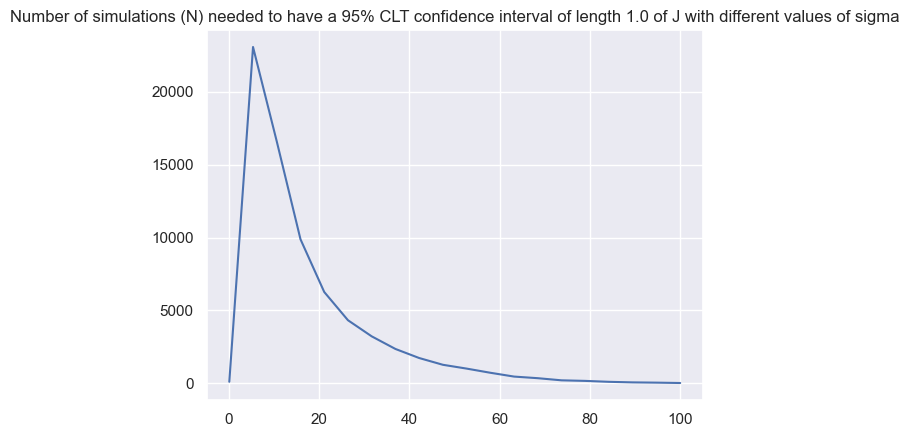

In [98]:
K, S0, r, T, I_market = 120, 100, 0.05, 0.2, 22
N,m = 100000,50
tol = 1/2

sigma_values = np.linspace(0.1, 100, 20)
St_dev = np.zeros(shape=(len(sigma_values),))

for i,sigma in enumerate(sigma_values):
    simulations = Simulate_Stock_Price(S0, sigma , r, T, m= 50, N=N)
    avg_stock_prices = np.mean(simulations, axis=1)
    Z = np.exp(-r*T) * np.maximum(K - avg_stock_prices, 0) - I_market
    St_dev[i] = np.std(Z)

plt.plot(sigma_values, ((1.96*St_dev/tol )**2))
plt.title(f"Number of simulations (N) needed to have a 95% CLT confidence interval of length {2*tol} of J with different values of sigma")


In [100]:
sigma = 0.8
N,m = 4000,50
alpha = 0.05
tol = 0.5

#Generate N simulations of the GBM
simulations = Simulate_Stock_Price(S0, sigma , r, T, m=50, N=N)
avg_stock_prices = np.mean(simulations, axis=1)
Z = np.exp(-r*T) * np.maximum(K - avg_stock_prices, 0) - I_market
Jhat = np.mean(Z)
Jhat_sd = np.std(Z)
Jhat_skew = st.skew(Z)

#Intervals
margin = 1.96 * Jhat_sd / np.sqrt(N)
lower_bound = Jhat - margin
upper_bound = Jhat + margin

print(f"CLT 95% Confidence Interval: ({lower_bound}, {upper_bound})")

margin = Jhat_sd / np.sqrt(alpha*N)
lower_bound = Jhat - margin
upper_bound = Jhat + margin
# Chebyshev
print(f"Chebyshev 95% Confidence Interval: ({lower_bound}, {upper_bound})")

k = 0.4748
xalpha = st.norm.ppf(k * Jhat_sd * Jhat_skew**3/(np.sqrt(N) *  Jhat_sd**3) + 1 - alpha/2)
margin = xalpha * Jhat_sd / np.sqrt(N)
lower_bound = Jhat - margin
upper_bound = Jhat + margin
# Barry-Essen
print(f"Barry-Essen 95% Confidence Interval: ({lower_bound}, {upper_bound})")

# Annexe
print(f"standard deviation for sigma={sigma} is {Jhat_sd}")
print(f"A 95% CLT confidence interval yields that we need {int((1.96*Jhat_sd/tol )**2)} simulations to have a 95% confidence interval of length {2*tol} for sigma = {sigma}")


CLT 95% Confidence Interval: (-0.7634691521313812, 0.23845604572631357)
Chebyshev 95% Confidence Interval: (-1.405553926049336, 0.8805408196442681)
Barry-Essen 95% Confidence Interval: (-0.7634616687001381, 0.23844856229507033)
standard deviation for sigma=0.8 is 16.165130971148834
A 95% CLT confidence interval yields that we need 4015 simulations to have a 95% confidence interval of length 1.0 for sigma = 0.8


In [115]:
def RM_Asian_mean_sd(n, N, rho, K, S0, T, r, I_market, m, sigma_0=1):
    """ Crude MonteCarlo estimator for Robin_Monro algorithm
    Parameters
    ----------
    sigma : float
        volatility of the geometric brownian motion
    N : int
        Size of the sample size for the estimation of the expected value
    K : float
        strike price of the put option
    S_0 : float
        Initial value of the geometric brownian motion
    r : float
        interest rate of the put option
    T : float
        time horizon of the put option
    I_market : float
        consistent mark to market price of the put option
    m : int
        number of time steps
    
    Returns
    -------
    J : float
        Crude MonteCarlo estimator of the the expected value of the payoff of the put option"""

    alpha_0 = 2/(K+S0)
    tol = 1 

    sigma_estim = np.empty((n,))
    mean_it = np.empty((n,))

    sigma_estim[0] = sigma_0
    
    simulations = Simulate_Stock_Price(S0, sigma_0 , r, T, m, N)
    avg_stock_prices = np.mean(simulations, axis=1)
    Z = np.exp(-r*T) * np.maximum(K - avg_stock_prices, 0) - I_market
    mean_it[0] = np.mean(Z)


    for i in range(1, n):
        alpha_n = alpha_0 / i ** rho
        sigma_cur = sigma_estim[i - 1]

        # Calculate Jhat
        simulations = Simulate_Stock_Price(S0, sigma_cur, r, T, m, N)
        avg_stock_prices = np.mean(simulations, axis=1)
        payoffs = np.exp(-r*T) * np.maximum(K - avg_stock_prices, 0)
        Jhat = np.mean(payoffs) - I_market
        
        sigma_estim[i] = sigma_cur - alpha_n * Jhat
        mean_it[i] = Jhat


    return sigma_estim,mean_it

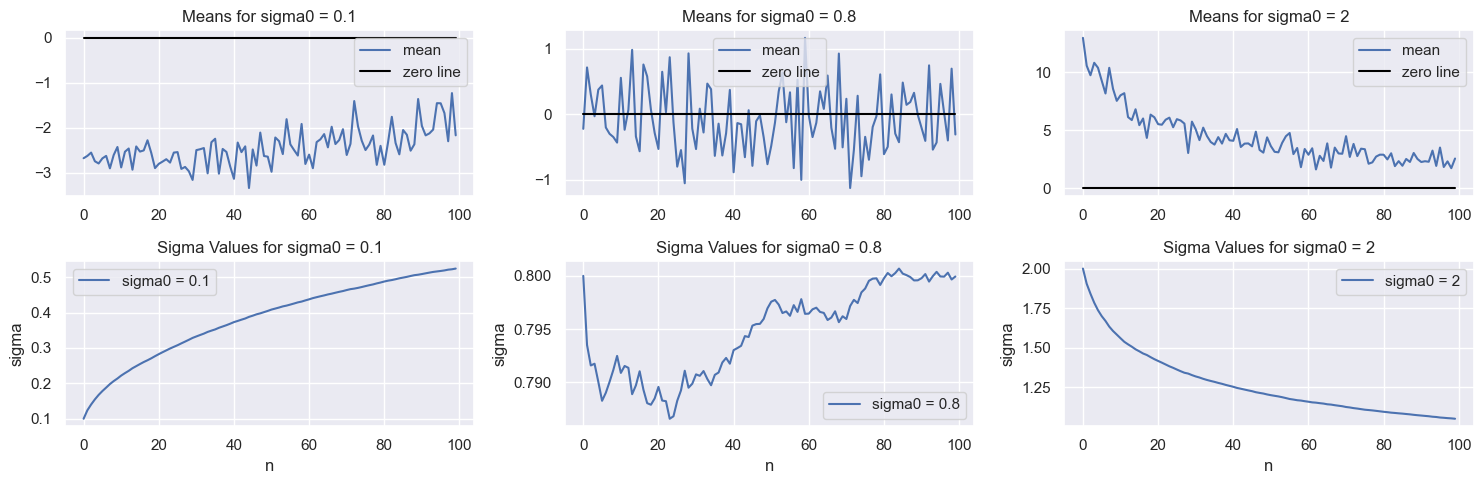

In [120]:
n = 100
N = 1000
K, S0, r, T, I_market = 120, 100, 0.05, 0.2, 22
sigma0_values = [0.1,0.8,2]


fig, axs = plt.subplots(2, 3, figsize=(15, 5))

for i, sigma0 in enumerate(sigma0_values):
    
    sigmas,means = RM_Asian_mean_sd(n, N, rho=0.5, K=K, S0=S0, T=T, r=r, I_market=I_market, m=30,sigma_0 = sigma0)

    # Plotting means in the first column
    axs[0, i].plot(means, label='mean')
    axs[0, i].plot(np.zeros(shape=(n,)),color='black',label='zero line')
    axs[0, i].set_title(f'Means for sigma0 = {sigma0}')
    axs[0, i].legend()

    # Plotting sigma values in the third column
    axs[1, i].plot(range(n), sigmas, label=f'sigma0 = {sigma0}')
    axs[1, i].set_title(f'Sigma Values for sigma0 = {sigma0}')
    axs[1, i].legend()
    axs[1, i].set_xlabel('n')
    axs[1, i].set_ylabel('sigma')

plt.tight_layout()
plt.show()


Drop first 2000 values (Burn in period)

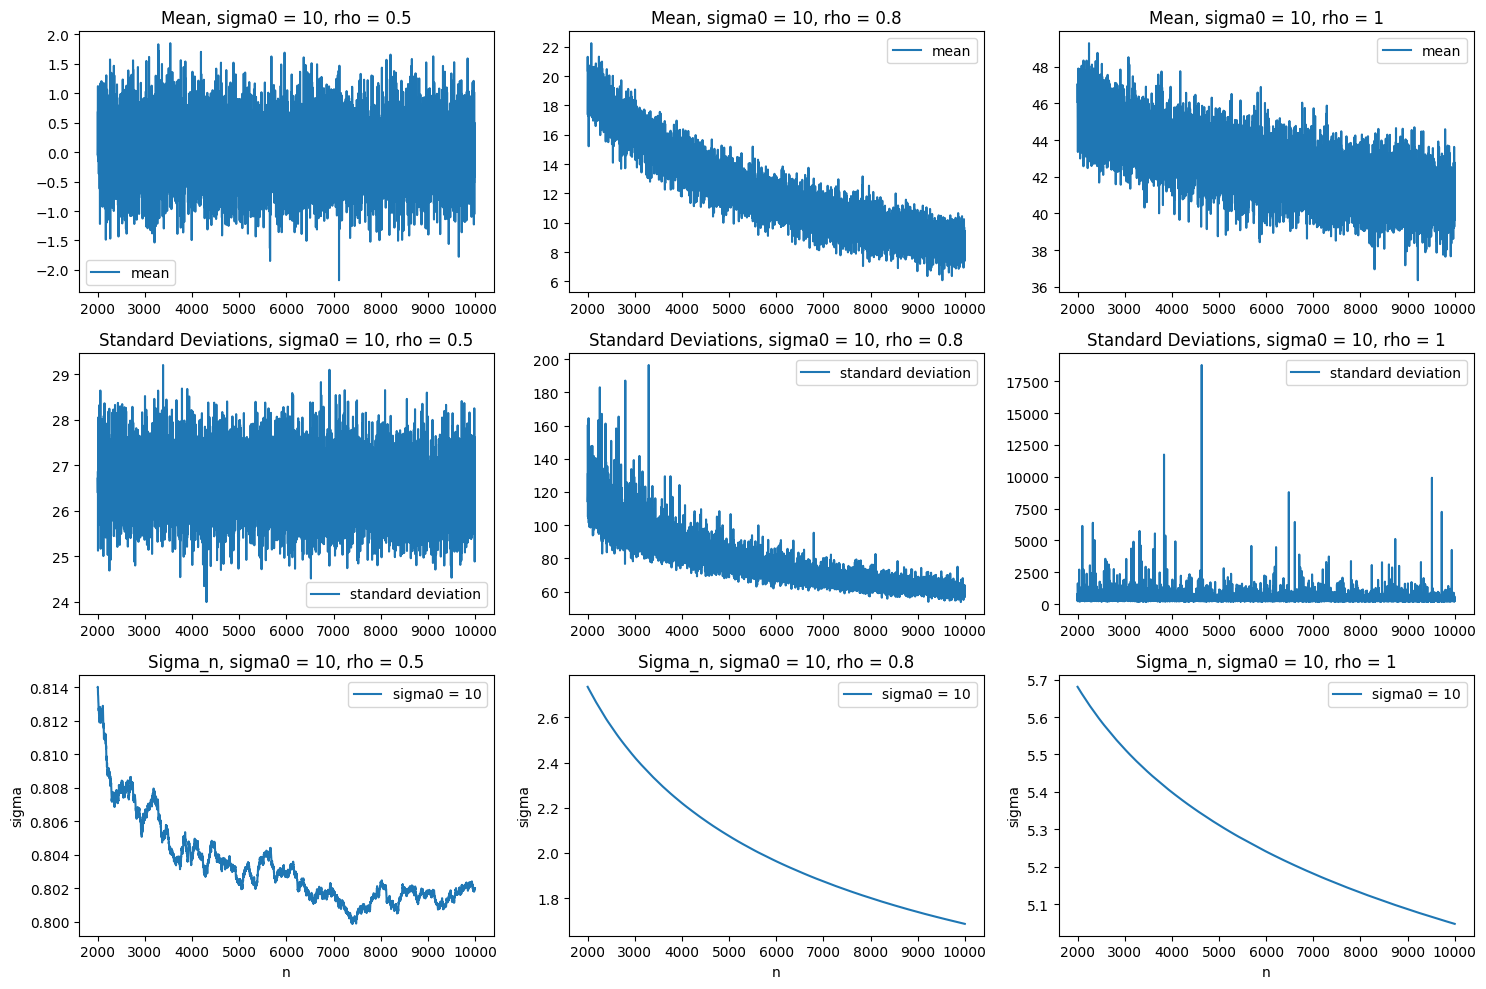

In [74]:
n = 10000
N = 1000
K, S0, r, T, I_market = 120, 100, 0.05, 0.2, 22
sigma0 = 10
rho_values = [0.5,0.8,1]


# Creating a 3x3 grid of plots
fig, axs = plt.subplots(3, 3, figsize=(15, 10))  # 3 rows, 3 columns

for i, rho in enumerate(rho_values):
    
    sigmas,means,sds = RM_Asian_mean_sd(n, N, rho= rho, K=K, S0=S0, T=T, r=r, I_market=I_market, m=30,sigma_0 = sigma0)

    # Plotting means in the first column
    axs[0, i].plot(range(n), means, label='mean')
    axs[0, i].set_title(f'Mean, sigma0 = {sigma0}, rho = {rho}')
    axs[0, i].legend()

    # Plotting standard deviations (excluding first 20 values) in the second column
    axs[1, i].plot(range(n), sds, label='standard deviation')
    axs[1, i].set_title(f'Standard Deviations, sigma0 = {sigma0}, rho = {rho}')
    axs[1, i].legend()

    # Plotting sigma values in the third column
    axs[2, i].plot(range(n), sigmas, label=f'sigma0 = {sigma0}')
    axs[2, i].set_title(f'Sigma_n, sigma0 = {sigma0}, rho = {rho}')
    axs[2, i].legend()
    axs[2, i].set_xlabel('n')
    axs[2, i].set_ylabel('sigma')

plt.tight_layout()
plt.show()

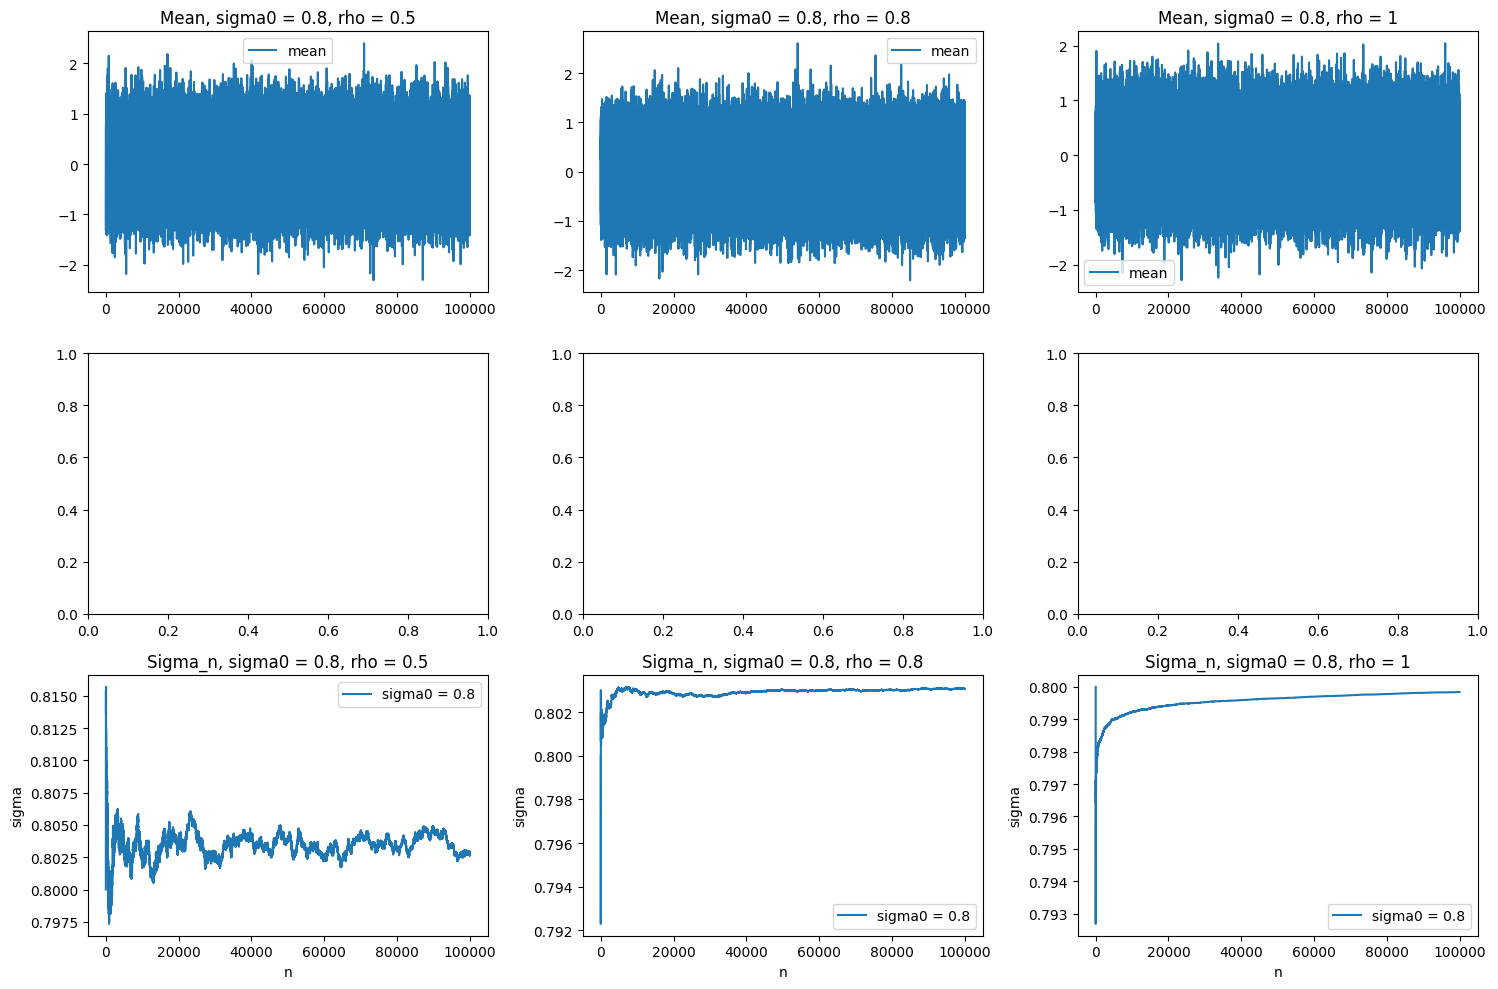

In [89]:
n = 10000
N = 1000
K, S0, r, T, I_market = 120, 100, 0.05, 0.2, 22
sigma0 = 0.8
rho_values = [0.5,0.8,1]


# Creating a 3x3 grid of plots
fig, axs = plt.subplots(3, 2, figsize=(15, 10))  # 3 rows, 3 columns

for i, rho in enumerate(rho_values):
    
    sigmas,means,sds = RM_Asian_mean_sd(n, N, rho= rho, K=K, S0=S0, T=T, r=r, I_market=I_market, m=30,sigma_0 = sigma0)

    # Plotting means in the first column
    axs[0, i].plot(range(n), means, label='mean')
    axs[0, i].set_title(f'Mean, sigma0 = {sigma0}, rho = {rho}')
    axs[0, i].legend()

    # Plotting sigma values in the third column
    axs[2, i].plot(range(n), sigmas, label=f'sigma0 = {sigma0}')
    axs[2, i].set_title(f'Sigma_n, sigma0 = {sigma0}, rho = {rho}')
    axs[2, i].legend()
    axs[2, i].set_xlabel('n')
    axs[2, i].set_ylabel('sigma')

plt.tight_layout()
plt.show()

Question 6: Importance Sampling

In [91]:
def calculate_bounds(r, T, S0, K, m):
    diff = K - S0 * np.mean(np.exp(r * np.arange(1,m+1) * T / m))
    diff = diff if diff > 0 else 0
    return str((np.exp(-r*T)*diff, np.exp(-r*T)*K))

print('Old bounds for I_market: ' + calculate_bounds(r=0.05, T=0.2, S0=100, K=120, m=50))
print('New bounds for I_market: ' + calculate_bounds(r=0.05, T=0.2, S0=100, K=80, m=50))

Old bounds for I_market: (19.294367043657672, 118.80598004990017)
New bounds for I_market: (0.0, 79.20398669993345)


Basic understanding of the pdf of lognormal and f (asian put option)

First dimension 1, i.e. m=1 

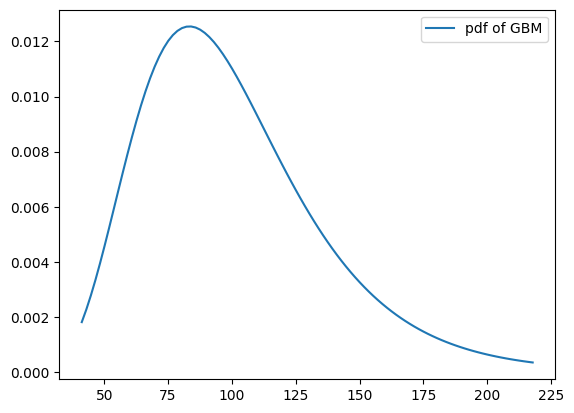

The mean of GBM is 101.00501670841683 and the standard deviation is 37.324463336559596
 99% of the mass of the distribution is between 41.21781922368857 and 217.77658627668333


In [212]:
K, S0, r, T, I_market = 80, 100, 0.05, 0.2, 22
sigma = 0.8

mu_N = np.log(S0) + (r-0.5*sigma**2) * T
sd_N = np.sqrt( sigma ** 2 * T)

x = np.linspace(st.lognorm.ppf(0.01, scale = np.exp(mu_N), s = sd_N),st.lognorm.ppf(0.99, scale = np.exp(mu_N), s = sd_N),100)
z = st.lognorm.pdf(x, scale = np.exp(mu_N), s = sd_N)
z2 = np.zeros(shape=(len(x)))
z2 = np.exp(-r*T) * np.maximum( 0,(K - x) )

plt.plot(x,z, label = "pdf of GBM")

plt.legend()
plt.show()
print(f"The mean of GBM is { np.exp( mu_N + (sd_N**2) / 2)} and the standard deviation is { np.sqrt( (np.exp(sd_N ** 2) - 1) * np.exp(2 * mu_N + sd_N ** 2) )}")
print(f" 99% of the mass of the distribution is between {st.lognorm.ppf(0.01, scale = np.exp(mu_N), s = sd_N)} and {st.lognorm.ppf(0.99, scale = np.exp(mu_N), s = sd_N)}")

In [213]:
alpha = 0.05

q = st.lognorm.ppf(1-alpha, scale = np.exp(mu_N), s = sd_N)
print(f" There is a {alpha} probability that the GBM is bigger than {q} with r = {r}")

r_tilde = -3.7

mu_N_tilde = np.log(S0) + (r_tilde-0.5*sigma**2) * T

q = st.lognorm.ppf(1-alpha, scale = np.exp(mu_N_tilde), s = sd_N)
print(f" There is a {alpha} probability that the GBM is bigger than {q} with r_tilde = {r_tilde}")  

 There is a 0.05 probability that the GBM is bigger than 170.6561834952307 with r = 0.05
 There is a 0.05 probability that the GBM is bigger than 80.61227310158017 with r_tilde = -3.7


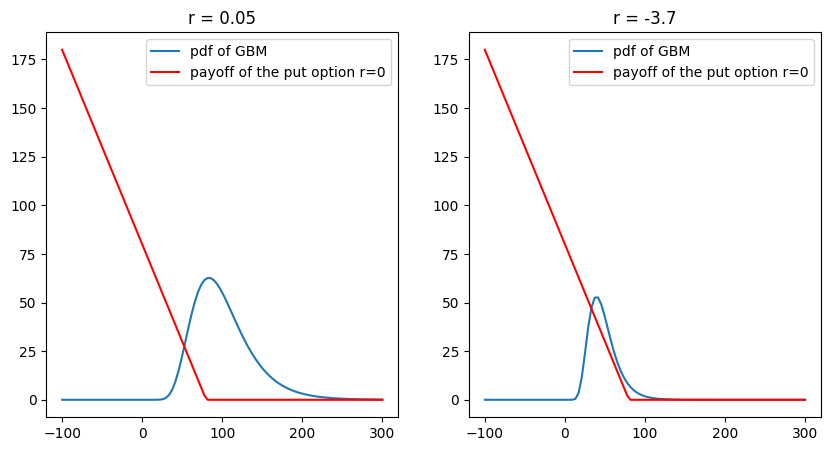

In [214]:
x = np.linspace(-100,300,100)
y = np.maximum( 0,(K - x) )

fig, axes = plt.subplots(1,2,figsize=(10, 5))

z = 5000 * st.lognorm.pdf(x, scale = np.exp(mu_N), s = sd_N)
z_tilde = 2000 * st.lognorm.pdf(x, scale = np.exp(mu_N_tilde), s = sd_N)

axes[0].plot(x,z, label = "pdf of GBM")
axes[0].plot(x,y, label = "payoff of the put option r=0", color= "red")
axes[0].legend()
axes[0].set_title("r = 0.05")

axes[1].plot(x,z_tilde, label = "pdf of GBM")
axes[1].plot(x,y, label = "payoff of the put option r=0", color= "red")
axes[1].legend()
axes[1].set_title(f"r = {r_tilde}")

plt.legend()
plt.show()

How the distribution of the lognormal changes with r:

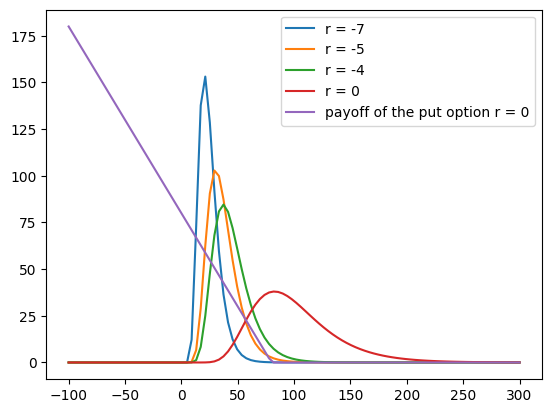

In [215]:
r_values = [-7,-5,-3-1,0]

for i in range(len(r_values)):

    mu_N = np.log(S0) + (r_values[i]-0.5*sigma**2) * T

    z = 3000 *st.lognorm.pdf(x, scale = np.exp(mu_N), s = sd_N)
    z2 = np.maximum( 0,(K - x) )

    plt.plot(x,z, label = f"r = {r_values[i]}")


plt.plot(x,y, label = f"payoff of the put option r = 0")
plt.legend()
plt.show()

Actually I want to approximate f(x)*p(x)

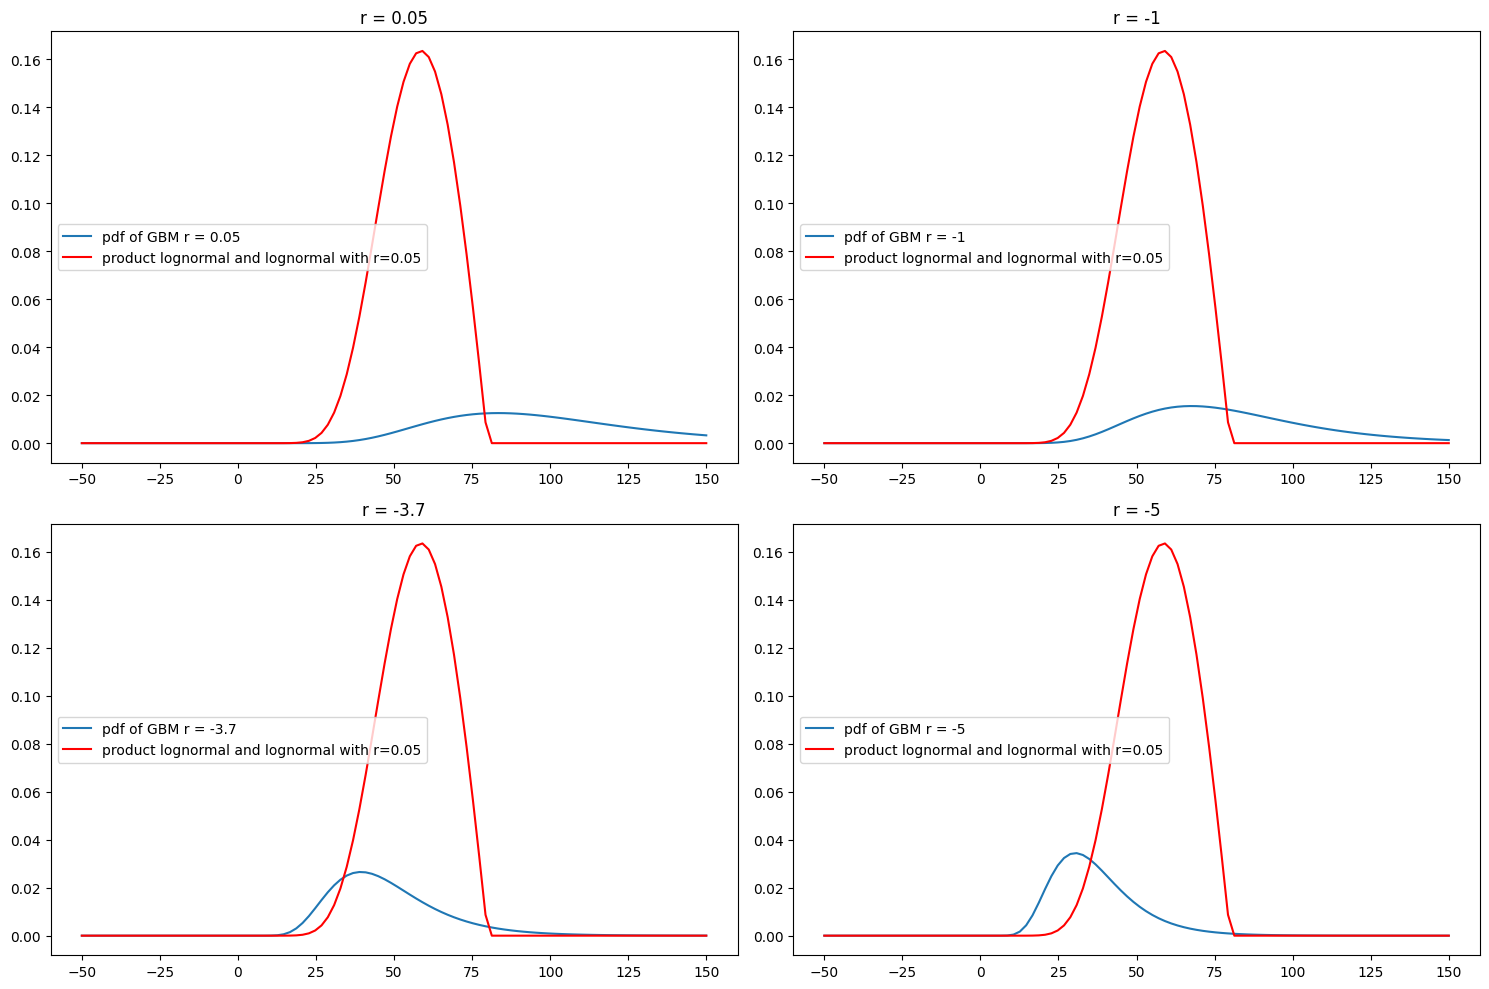

In [265]:
K, S0, r, T, I_market = 80, 100, 0.05, 0.2, 22
sigma = 0.8

x = np.linspace(-50,150,100)
y = np.exp(-r*T)*np.maximum( 0,(K - x) )

mu_N = np.log(S0) + (r-0.5*sigma**2) * T
z = st.lognorm.pdf(x, scale = np.exp(mu_N), s = sd_N) 
g = z * y 

r_values = [0.05,-1,-3.7,-5,]

fig, axes = plt.subplots(2,2,figsize=(15, 10))

for i, r in enumerate(r_values):
    mu_N_tilde = np.log(S0) + (r-0.5*sigma**2) * T
    z_tilde = st.lognorm.pdf(x, scale = np.exp(mu_N_tilde), s = sd_N)

    axes[i//2,i%2].plot(x,z_tilde, label = f"pdf of GBM r = {r}")
    axes[i//2,i%2].plot(x,g, label = f"product lognormal and lognormal with r=0.05", color= "red")
    axes[i//2,i%2].legend()
    axes[i//2,i%2].set_title(f"r = {r_values[i]}")

plt.tight_layout()

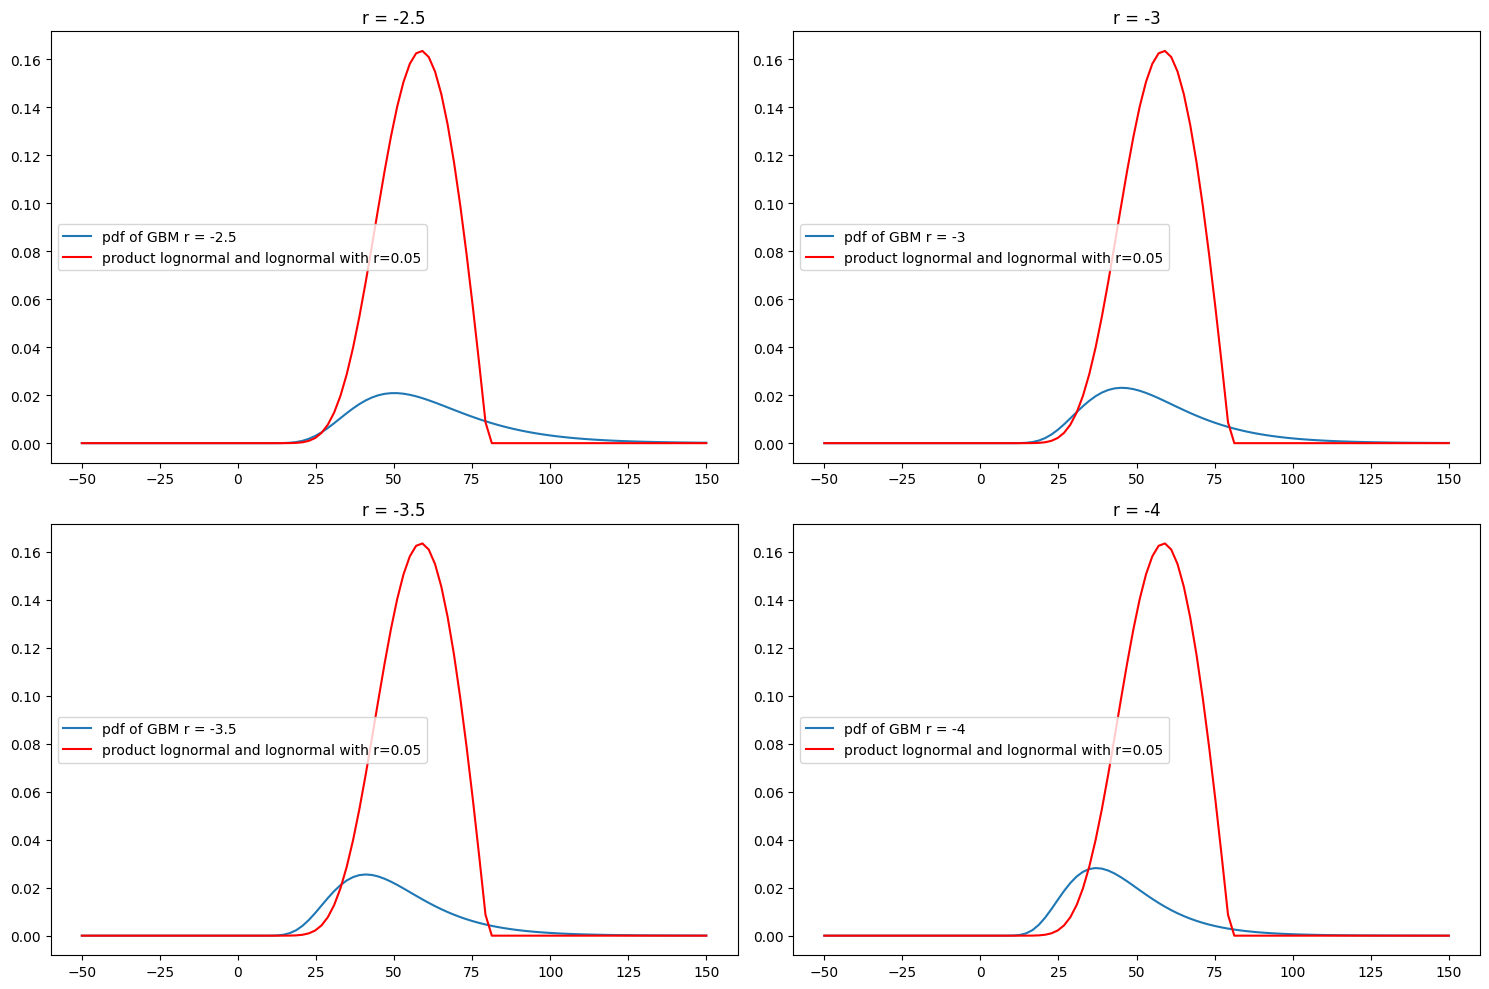

In [337]:
K, S0, r, T, I_market = 80, 100, 0.05, 0.2, 22
sigma = 0.8

x = np.linspace(-50,150,100)
y = np.exp(-r*T)*np.maximum( 0,(K - x) )

mu_N = np.log(S0) + (r-0.5*sigma**2) * T
z = st.lognorm.pdf(x, scale = np.exp(mu_N), s = sd_N) 
g = z * y 

r_values = [-2.5,-3,-3.5,-4]

fig, axes = plt.subplots(2,2,figsize=(15, 10))

for i, r in enumerate(r_values):
    mu_N_tilde = np.log(S0) + (r-0.5*sigma**2) * T
    z_tilde = st.lognorm.pdf(x, scale = np.exp(mu_N_tilde), s = sd_N)

    axes[i//2,i%2].plot(x,z_tilde, label = f"pdf of GBM r = {r}")
    axes[i//2,i%2].plot(x,g, label = f"product lognormal and lognormal with r=0.05", color= "red")
    axes[i//2,i%2].legend()
    axes[i//2,i%2].set_title(f"r = {r_values[i]}")

plt.tight_layout()

Let us compute the mean value of our geometric brownian path

In [372]:
K, S0, r, T, I_market = 80, 100, 0.05, 0.2, 22
sigma = 0.8
m = 50
Q=[]

for i in range(1,51):
    Q = np.append(Q,S0 * np.exp( (r-sigma**2/2) * T/m * i * (i-1) / 2 ))

mu_path = np.mean(Q)
print(f"The mean of the path is {mu_path}")

mu_N = np.log(mu_path) + (r-0.5*sigma**2) * T
sd_N = np.sqrt( sigma ** 2 * T)

print(f"The mean of GBM is { np.exp( mu_N + (sd_N**2) / 2)}")
print(f" 99% of the mass of the distribution is between {st.lognorm.ppf(0.01, scale = np.exp(mu_N), s = sd_N)} and {st.lognorm.ppf(0.99, scale = np.exp(mu_N), s = sd_N)}")


The mean of the path is 68.63071133315138
The mean of GBM is 69.32046144915488
 99% of the mass of the distribution is between 28.288082529229882 and 149.46162027874192


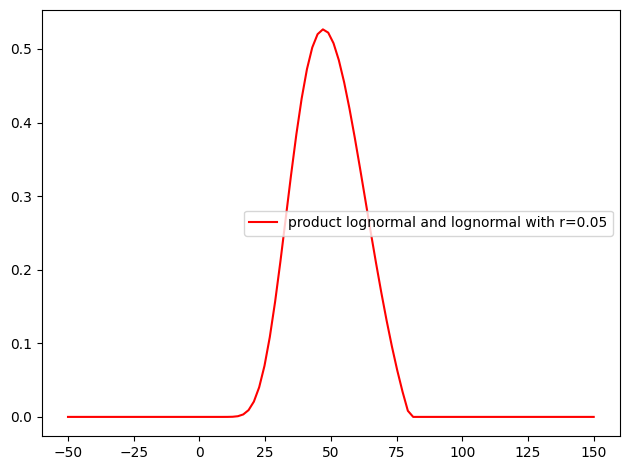

The mean of g is 47.139471394713944


In [385]:
x = np.linspace(-50,150,100)
y = np.exp(-r*T)*np.maximum( 0,(K - x) )
z = st.lognorm.pdf(x, scale = np.exp(mu_N), s = sd_N) 
g = z * y 

plt.plot(x,g, label = f"product lognormal and lognormal with r=0.05", color= "red")
plt.legend()
plt.tight_layout()
plt.show()

# Retrieve the max of f * p, which is in between 0 and 100 and it is the mean of this new pdf called g
x = np.linspace(0,100,100000)
y = np.exp(-r*T)*np.maximum( 0,(K - x) )

z = st.lognorm.pdf(x, scale = np.exp(mu_N), s = sd_N) 
g = z * y 

mu_g = x[np.argmax(g)]
print(f"The mean of g is {mu_g}")

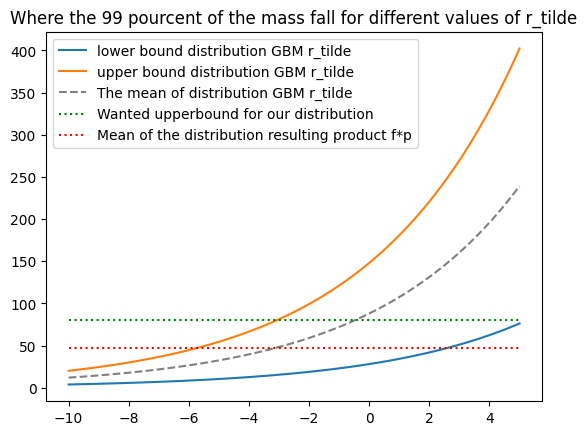

In [424]:
r = np.linspace(-10,5,100)
sd_N = np.sqrt( sigma ** 2 * T)
y1 = []
y2 = []
ligne_k = np.full(100,K)
ligne_mu_g = np.full(100,mu_g)
for i in range(100):

    mu_N = np.log(mu_path) + (r[i]-0.5*sigma**2) * T
    y1 = np.append(y1,st.lognorm.ppf(0.01, scale = np.exp(mu_N), s = sd_N))
    y2 = np.append(y2,st.lognorm.ppf(0.99, scale = np.exp(mu_N), s = sd_N))

y3 = (y1+y2)/2
plt.plot(r,y1, label = "lower bound distribution GBM r_tilde")
plt.plot(r,y2, label = "upper bound distribution GBM r_tilde")
plt.plot(r,y3, label = "The mean of distribution GBM r_tilde", color="grey",linestyle='--')
plt.plot(r,ligne_k, label = "Wanted upperbound for our distribution",color="green",linestyle='dotted')
plt.plot(r,ligne_mu_g, label = "Mean of the distribution resulting product f*p",color="red",linestyle='dotted')
plt.title("Where the 99 pourcent of the mass fall for different values of r_tilde")
plt.legend()
plt.show()

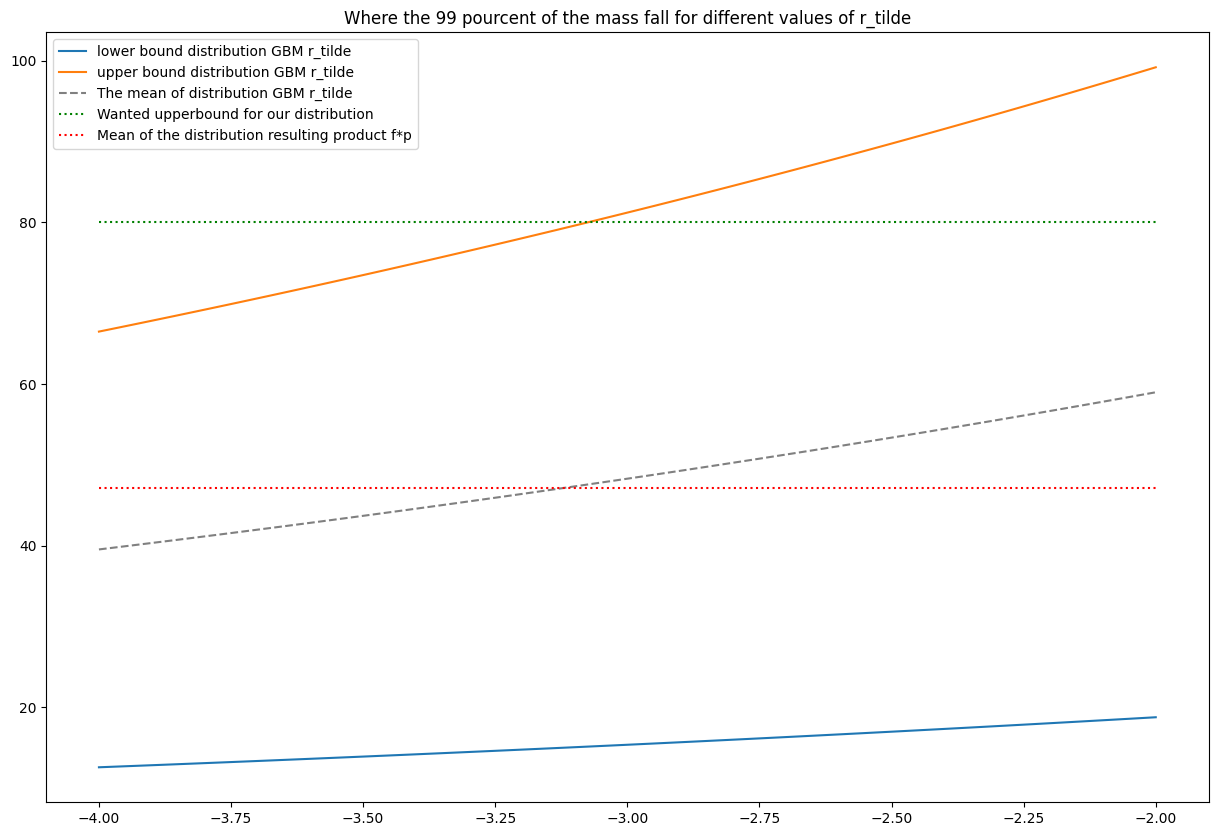

In [425]:
r = np.linspace(-4,-2,100)
sd_N = np.sqrt( sigma ** 2 * T)
y1 = []
y2 = []
ligne_k = np.full(100,K)
ligne_mu_g = np.full(100,mu_g)
for i in range(100):

    mu_N = np.log(mu_path) + (r[i]-0.5*sigma**2) * T
    y1 = np.append(y1,st.lognorm.ppf(0.01, scale = np.exp(mu_N), s = sd_N))
    y2 = np.append(y2,st.lognorm.ppf(0.99, scale = np.exp(mu_N), s = sd_N))

y3 = (y1+y2)/2
plt.figure(figsize=(15,10))
plt.plot(r,y1, label = "lower bound distribution GBM r_tilde")
plt.plot(r,y2, label = "upper bound distribution GBM r_tilde")
plt.plot(r,y3, label = "The mean of distribution GBM r_tilde", color="grey",linestyle='--')
plt.plot(r,ligne_k, label = "Wanted upperbound for our distribution",color="green",linestyle='dotted')
plt.plot(r,ligne_mu_g, label = "Mean of the distribution resulting product f*p",color="red",linestyle='dotted')
plt.title("Where the 99 pourcent of the mass fall for different values of r_tilde")
plt.legend()
plt.show()

Back to exercise

In [426]:
# Part a) Use IS to approximate I(sigma). Note: Jhat(sigma) = Ihat(sigma) - I_market

# Calculate likelihood ratio
def w(S_T, S_0, sigma, r, r_tilde, T):
    return (S_T/S_0)**((r - r_tilde)/sigma**2) * np.exp((r+r_tilde-sigma**2)*(-r+r_tilde)*T/(2*sigma**2))

def RM_Asian_with_IS(n, N, rho, K, S0, T, r, r_tilde, I_market, m, sigma_0 = 1):
    alpha_0 = 2/(K+S0)

    sigma_estim = np.empty((n,))
    sigma_estim[0] = sigma_0
    
    for i in range(1, n):
        alpha_n = alpha_0 / i ** rho
        sigma_cur = sigma_estim[i - 1]

        # Calculate Jhat with IS
        simulations = Simulate_Stock_Price(S0, sigma_cur, r_tilde, T, m, N)
        likelihood_ratios = w(simulations[:, -1], S0, sigma_cur, r, r_tilde, T)
        avg_stock_prices = np.mean(simulations, axis=1)
        payoffs = np.exp(-r*T) * np.maximum(K - avg_stock_prices, 0)
        Jhat = np.mean(np.multiply(payoffs, likelihood_ratios)) - I_market

        sigma_estim[i] = sigma_cur - alpha_n * Jhat

    return sigma_estim

NameError: name 'RM_Asian' is not defined

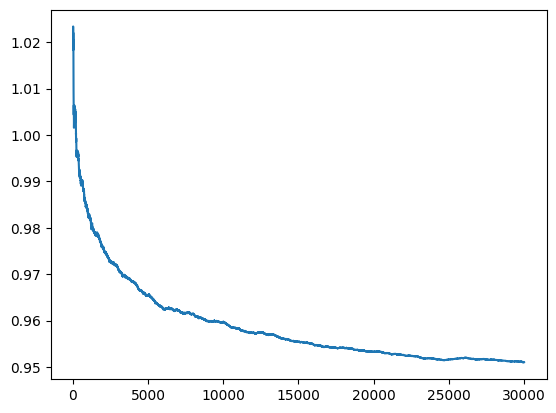

In [427]:
n, N, rho = 30000, 10, 0.8
K, S0, T, r, I_market = 80, 100, 0.2, 0.05, 2
r_tilde = 10**-6
m = 30

sigmas_IS = RM_Asian_with_IS(n, N, rho, K, S0, T, r, r_tilde, I_market, m)
plt.plot(range(21,n+1), sigmas_IS[20:], label="with IS")

sigmas = RM_Asian(n, N, rho, K, S0, T, r, I_market, m)
plt.plot(range(21,n+1), sigmas[20:], label="without IS")

plt.xlabel('n')
plt.ylabel('sigma')
plt.legend()

In [ ]:
# Question 7
from scipy.optimize import minimize_scalar

K, S0, T, r = 80, 100, 0.2, 0.05
m = 30
N = 100
def find_optimal_r_tilde(sigmas, S0, K, r, T, m, N):
    def g(eta, sigma, simulations):
        likelihood_ratios = w(simulations[:, -1], S0, sigma, r, eta, T)
        
        avg_stock_prices = np.mean(simulations[:, 1:], axis=1)
        payoffs_squared = (np.exp(-r*T) * np.maximum(K - avg_stock_prices, 0))**2
        variance = np.mean(np.multiply(payoffs_squared, likelihood_ratios))
        return variance
    
    if type(sigmas) == float:
        simulations = Simulate_Stock_Price(S0, sigma, r, T, m, N)
        return minimize_scalar(g, args=(sigmas,simulations), bounds = (0, 1)).x
    else:
        result = {}
        for sigma in sigmas:
            simulations = Simulate_Stock_Price(S0, sigma, r, T, m, N)
            result[sigma] = minimize_scalar(g, args=(sigma,simulations), bounds = (0, 1)).x

        return result
sigmas = np.linspace(0.3, 5, num=1000)
result = find_optimal_r_tilde(sigmas, S0, K, r, T, m, N)
print(result)

{0.3: 0.9999940391390134, 0.3047047047047047: 4.053349035892279e-06, 0.3094094094094094: 0.9999940391390134, 0.3141141141141141: 0.9999940391390134, 0.3188188188188188: 0.9999940391390134, 0.32352352352352354: 3.886417458363482e-06, 0.3282282282282282: 3.407834306590374e-06, 0.3329329329329329: 3.475145347567674e-06, 0.33763763763763766: 4.089108502423367e-06, 0.34234234234234234: 0.9999940391390134, 0.34704704704704703: 0.9999940391390134, 0.3517517517517518: 0.9999940391390134, 0.35645645645645646: 5.735157473386274e-06, 0.36116116116116115: 3.7621961747660863e-06, 0.3658658658658659: 0.9999940391390134, 0.3705705705705706: 0.9999940391390134, 0.37527527527527527: 4.482145974429293e-06, 0.37997997997997995: 4.8443598223780375e-06, 0.38468468468468464: 6.644965291640485e-06, 0.3893893893893894: 4.283915299872466e-06, 0.39409409409409407: 5.504458261216802e-06, 0.39879879879879876: 4.5487157770817075e-06, 0.4035035035035035: 3.668720812622367e-06, 0.4082082082082082: 5.514556211439587e

In [ ]:
def RM_Asian_with_IS_opt(n, N, rho, K, S0, T, r, I_market, m, sigma_0=1):
    alpha_0 = 2/(K+S0)

    sigma_estim = np.empty((n,))
    sigma_estim[0] = sigma_0
    
    for i in range(1, n):
        alpha_n = alpha_0 / i ** rho
        sigma_cur = sigma_estim[i - 1]

        # Calculate Jhat with IS
        r_tilde = result[min(result, key=lambda x : abs(x - sigma_cur))]
        simulations = Simulate_Stock_Price(S0, sigma_cur, r_tilde, T, m, N)
        likelihood_ratios = w(simulations[:, -1], S0, sigma_cur, r, r_tilde, T)
        avg_stock_prices = np.mean(simulations, axis=1)
        payoffs = np.exp(-r*T) * np.maximum(K - avg_stock_prices, 0)
        Jhat = np.mean(np.multiply(payoffs, likelihood_ratios)) - I_market

        sigma_estim[i] = sigma_cur - alpha_n * Jhat

    return sigma_estim

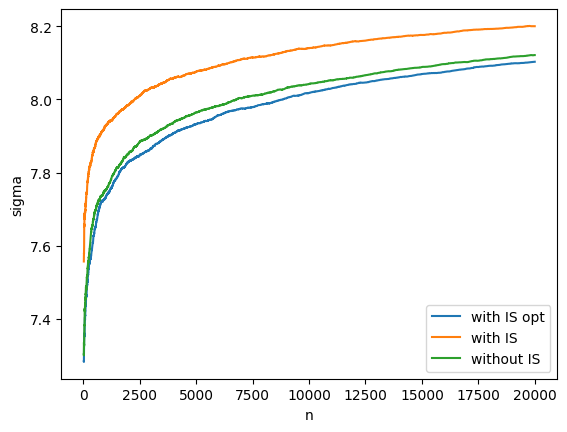

In [ ]:
n, N, rho = 20000, 10, 0.8
K, S0, T, r, I_market = 80, 100, 0.2, 0.05, 50
r_tilde = 10**-6
m = 30

sigmas_IS = RM_Asian_with_IS_opt(n, N, rho, K, S0, T, r, I_market, m, sigma_0=7)
plt.plot(range(21,n+1), sigmas_IS[20:], label="with IS opt")

sigmas_IS = RM_Asian_with_IS(n, N, rho, K, S0, T, r, r_tilde, I_market, m, sigma_0=7)
plt.plot(range(21,n+1), sigmas_IS[20:], label="with IS")

sigmas = RM_Asian(n, N, rho, K, S0, T, r, I_market, m, sigma_0=7)
plt.plot(range(21,n+1), sigmas[20:], label="without IS")

plt.xlabel('n')
plt.ylabel('sigma')
plt.legend()